In [ ]:
Keras를 사용한 전이학습

In [1]:
import numpy as np
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.preprocessing.image import load_img

# 상위의 FC 계층만 학습, 컨볼루션 계층의 가중치(ImageNet로 학습) 재사용
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
# 현재 경로에 flower_photos 폴더가 있다고 가정함
train_dir = './flower_photos/train'
validation_dir = './flower_photos/valid'
n_train = 500*3
n_val = 50*3
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 25

#학습용
train_features = np.zeros(shape=(n_train, 7, 7, 512))
train_labels = np.zeros(shape=(n_train,3))
train_generator = datagen.flow_from_directory(train_dir, target_size=(224,224), \
                                              batch_size=batch_size, class_mode='categorical', shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_model.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= n_train: break

train_features = np.reshape(train_features, (n_train, 7 * 7 * 512)) # 1차원 벡터화
        
#검증용
validation_features = np.zeros(shape=(n_val, 7, 7, 512))
validation_labels = np.zeros(shape=(n_val,3))
validation_generator = datagen.flow_from_directory(validation_dir, target_size=(224, 224), \
                                                   batch_size=batch_size, class_mode='categorical', shuffle=False)
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_model.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] =features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= n_val: break
        
validation_features = np.reshape(validation_features, (n_val, 7 * 7 * 512))   

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Found 1500 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
잘못 분류된 영상 시각화

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1500 samples, validate on 150 samples
Epoch 1/20
1500/1500 [==============================] - 17s 11ms/step - loss: 1.1559 - acc: 0.5553 - val_loss: 0.9976 - val_acc: 0.6067
Epoch 2/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.6049 - acc: 0.7680 - val_loss: 0.7968 - val_acc: 0.6600
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.4938 - acc: 0.8033 - val_loss: 0.7614 - val_acc: 0.6667
Epoch 4/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3997 - acc: 0.8393 - val_loss: 0.7097 - val_acc: 0.6933
Epoch 5/20
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3087 - acc: 0.8820 - val_loss: 0.6933 - val_acc: 0.6933
Epoch 6/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.2412 - acc: 0.9013 - val_loss: 

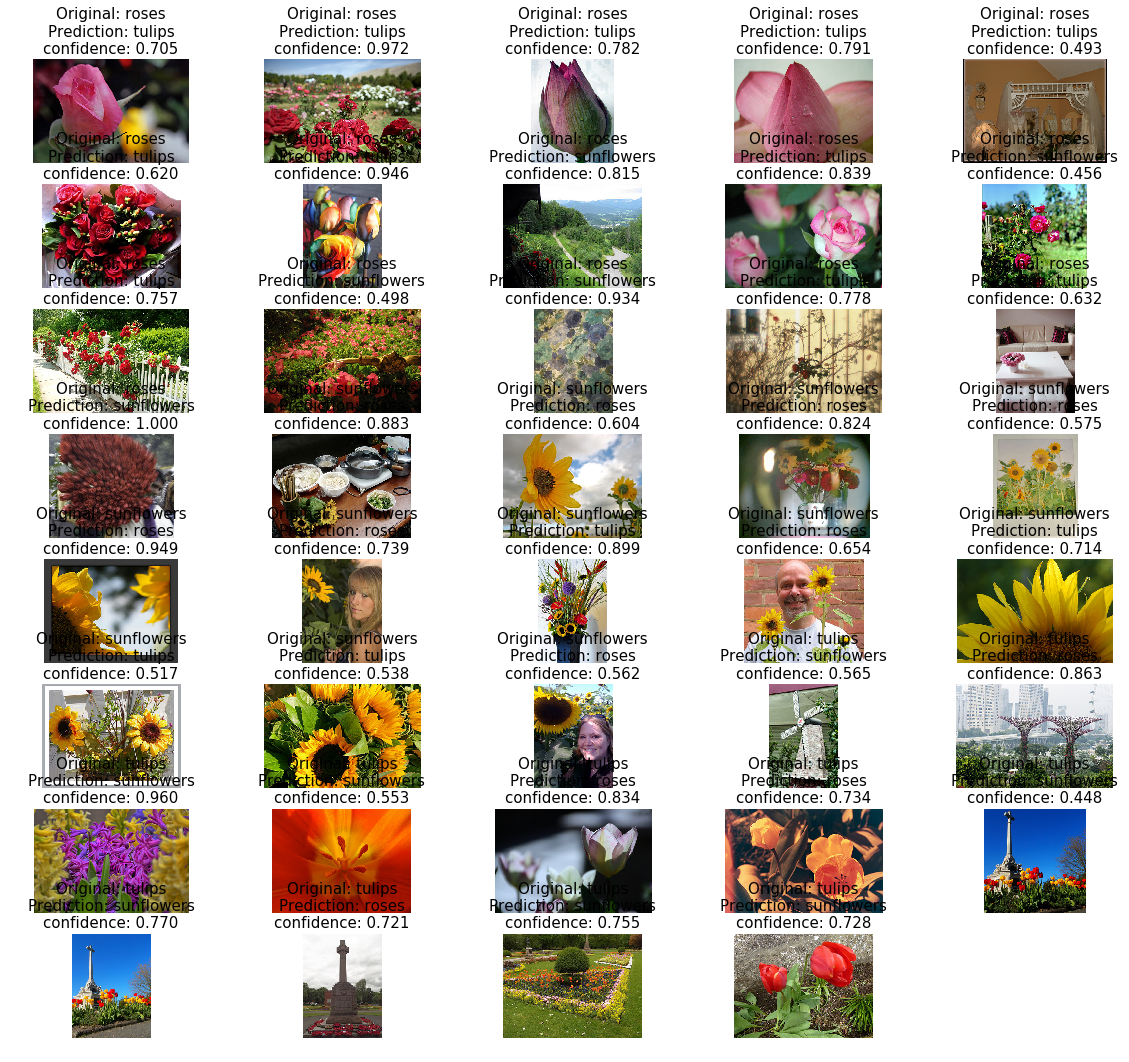

In [3]:
from keras.layers.normalization import BatchNormalization
import matplotlib.pylab as pylab

# 가지고 있는 영상으로 학습하여 FC 계층의 매개 변수 학습
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer=optimizers.Adam(lr=1e-5), \
              loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=20, \
                    batch_size=batch_size, \
                    validation_data=(validation_features, validation_labels))

filenames = validation_generator.filenames
ground_truth = validation_generator.classes
label2index = validation_generator.class_indices

# 클래스 인덱스에서 클래스 레이블로 매핑
idx2label = dict((v,k) for k,v in label2index.items())
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), n_val)) # No of errors = 13/150

rows = np.ceil(len(errors) / 5)
pylab.figure(figsize=(20,18))
for i, error in enumerate(errors):
    pred_class = np.argmax(prob[error])
    pred_label = idx2label[pred_class]
    original = load_img('{}/{}'.format(validation_dir, filenames[error]))
    pylab.subplot(rows, 5, i+1), pylab.imshow(original), pylab.axis('off')
    pylab.title('Original: {}\nPrediction: {}\nconfidence: {:.3f}'.\
                format(filenames[error].split('\\')[0], pred_label, \
                       prob[error][pred_class]), size=15)
pylab.show()